In [19]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

In [20]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')
df_synthetic_spec = pd.read_csv('../input/synthetic-samples-specific-disorder-ctgan/synthetic_samples_specific_disorder_ctgan.csv', index_col=0)
df_synthetic_main = pd.read_csv('../input/synthetic-samples-main-disorder-ctgan/synthetic_samples_main_disorder_ctgan.csv', index_col=0)

In [13]:
!pip install numpy pandas scipy matplotlib dython;

📊 Jensen-Shannon Divergence


AB.B.theta.g.F8       0.828745
AB.B.theta.q.T6       0.828125
AB.B.theta.f.F4       0.825246
AB.F.gamma.s.O2       0.824023
AB.B.theta.a.FP1      0.823993
AB.F.gamma.m.T5       0.823687
AB.E.highbeta.s.O2    0.822549
AB.C.alpha.i.C3       0.821618
AB.C.alpha.g.F8       0.818841
AB.C.alpha.n.P3       0.815431
Name: JSD, dtype: float64


→ Média da JSD: 0.3033
→ Mediana da JSD: 0.2345


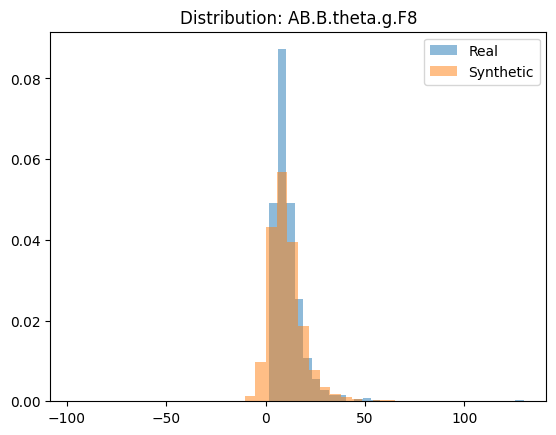

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.stats import ks_2samp
from scipy.special import rel_entr
import matplotlib.pyplot as plt
from dython.nominal import associations
from numpy.linalg import norm

ab_psd = df.filter(regex='^AB')
coh_fc = df.filter(regex='^COH')

ab_psd_synthetic = df_synthetic_spec.filter(regex='^AB')
coh_fc_synthetic = df_synthetic_spec.filter(regex='^COH')

psd_fc_real = pd.concat([ab_psd, coh_fc], axis=1)
psd_fc_synthetic = pd.concat([ab_psd_synthetic, coh_fc_synthetic], axis=1)


class SyntheticDataEvaluator:
    def __init__(self, real_df, synth_df):
        self.real_df = real_df.copy()
        self.synth_df = synth_df.copy()

    def _get_common_columns(self):
        return list(set(self.real_df.columns) & set(self.synth_df.columns))

    def kolmogorov_smirnov_test(self):
        common_cols = self._get_common_columns()
        ks_results = {}
        for col in common_cols:
            try:
                stat, p_value = ks_2samp(self.real_df[col], self.synth_df[col])
                ks_results[col] = {"statistic": stat, "p-value": p_value}
            except:
                continue
        return pd.DataFrame(ks_results).T

    def jensen_shannon_divergence(self, bins=50):
        jsd_results = {}
        for col in self._get_common_columns():
            try:
                p, _ = np.histogram(self.real_df[col], bins=bins, density=True)
                q, _ = np.histogram(self.synth_df[col], bins=bins, density=True)
                jsd = distance.jensenshannon(p + 1e-8, q + 1e-8)
                jsd_results[col] = jsd
            except:
                continue
        return pd.Series(jsd_results, name="JSD")

    def kl_divergence(self):
        kl_results = {}
        for col in self._get_common_columns():
            try:
                p = self.real_df[col].value_counts(normalize=True).sort_index()
                q = self.synth_df[col].value_counts(normalize=True).sort_index()
                p, q = p.align(q, fill_value=1e-8)
                kl = sum(rel_entr(p, q))
                kl_results[col] = kl
            except:
                continue
        return pd.Series(kl_results, name="KL Divergence")

    def pairwise_correlation_difference(self):
        common_cols = self._get_common_columns()
        real_corr = self.real_df[common_cols].corr()
        synth_corr = self.synth_df[common_cols].corr()
        diff = real_corr - synth_corr
        pcd = norm(diff.values)
        return pcd, diff

    def plot_distributions(self, column):
        plt.hist(self.real_df[column], bins=30, alpha=0.5, label='Real', density=True)
        plt.hist(self.synth_df[column], bins=30, alpha=0.5, label='Synthetic', density=True)
        plt.title(f'Distribution: {column}')
        plt.legend()
        plt.show()

evaluator = SyntheticDataEvaluator(psd_fc_real, psd_fc_synthetic)